# Project Guide

The notebook is broken up into the following sections:
- Data Wrangling
- EDA
- Data Processing
- Final Iteration CNN 
- Baseline CNN 
- Transfer Learning CNN
    * Accuracy graphs for Training and Validation are included in the folder called images. They did not populate when exporting the graphs from Colab. 

## Colab
- Google Colab proved invaluable to this project and analysis. Tensorflow and the new M1 chip in Mac are not capable greatly limiting the devices employability as a machine learning device. Google Colab offers an easily accessible alternative to nagivating this predicament. However, Colab has a few limitations when dealing with specific projects particularly image datasets of a large quantity. Several combinations of zipping and unzipping data from Google Drive directly into the temporary RAM of Colab resolves this issue, but isn't immediately obvious to newcomers to the platform. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from numpy.random import seed
seed(89)

import pandas as pd
import numpy as np
import os
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
tf.random.set_seed(89)

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6242728520664779547
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15505193728
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3139500069162626655
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
]


In [4]:
!cp /content/gdrive/MyDrive/project_dataset.zip .
!unzip -q project_dataset.zip

In [6]:
print(len(os.listdir('/content/project_dataset/test'))) # This test set was not used in the analysis because labels were not provided for the images
print(len(os.listdir('/content/project_dataset/train')))
os.listdir('/content/project_dataset')

57458
220025


['test', 'train', '.DS_Store', 'sample_submission.csv', 'train_labels.csv']

In [8]:
df_data = pd.read_csv('/content/project_dataset/train_labels.csv')
df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']
df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']
print(df_data.shape)
df_data['label'].value_counts()

(220025, 2)


0    130908
1     89117
Name: label, dtype: int64

In [ ]:
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

# EDA Visualization

- Images were randomly collected from the datat to contextual the challenge of hte project. These images highlight the divergence between tumor examples and non-tumor ones. The images on the top have not tumor tissue present displaying a cohesive dense cluster of circular cells with minimal patches in the slides. 
- The second row of images display irregularities in the tissue specificallly oblong shapes, more scattered nuclei, and larger pataches between the nuclei indicating unmititgated cellular grow commonly found in cancerous tissue. 

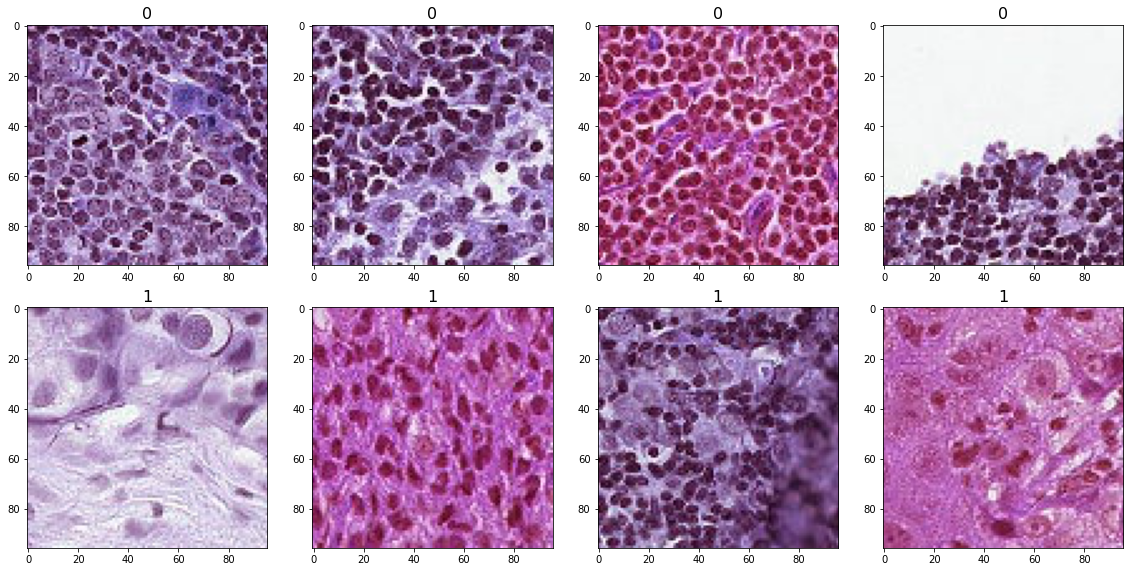

In [9]:
IMAGE_PATH = '/Users/alexandersigrist/documents/metis/git_repos/final project/histopathologic-cancer-detection/train/' 
draw_category_images('label',4, df_data, IMAGE_PATH)

# Resampling to Balance Classes and Directory Paths

- To balance the data for analysis, undersampling was undertaken to ensure a balanced foundation for analysis. 
- The data was split twice to create a test set and a validation set of data for analysis.
- The images were sorted into the corresponding folders for the CNN to analyze the images in the correct bins.

There are several ways to organize image data for CNN, but the most logical approach was to establish a balanced dataset split and then sort the images into the corresponding directories for ImageNet to pull the data from. 

In [ ]:
df_0=df_data[df_data['label']==0].sample(89000,random_state=89)
df_1=df_data[df_data['label']==1].sample(89000,random_state=89)
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
df_data = shuffle(df_data)

In [ ]:
y = df_data['label']
x, df_test = train_test_split(df_data, test_size=0.145, random_state=89, stratify=y)
y_strat = x['label']
df_train, df_val = train_test_split(x, test_size=0.145, random_state=89, stratify=y_strat)

In [ ]:
from pathlib import Path

balanced_dir='balanced_dir'
os.mkdir(balanced_dir)

train_dir = os.path.join(balanced_dir, 'train_dir')
os.mkdir(train_dir)

val_dir = os.path.join(balanced_dir, 'val_dir')
os.mkdir(val_dir)

no_tumor_tissue = os.path.join(train_dir, 'Alpha_zero_notumortissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'Beta_one_hastumortissue')
os.mkdir(has_tumor_tissue)

no_tumor_tissue = os.path.join(val_dir, 'Alpha_zero_notumortissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'Beta_one_hastumortissue')
os.mkdir(has_tumor_tissue)
df_data.set_index('id', inplace=True)

In [ ]:
df_data.set_index('id', inplace=True)

In [ ]:
train_list = list(df_train['id'])
val_list = list(df_val['id'])

count1=1

for image in train_list:
    fname = image + '.tif'
    target = df_data.loc[image,'label']
    
    print(count1)
    if target == 0:
        label = 'Alpha_zero_notumortissue'
    if target == 1:
        label = 'Beta_one_hastumortissue'
    
    src = os.path.join('/content/project_dataset/train', fname)
    dst = os.path.join(train_dir, label, fname)
    shutil.copyfile(src, dst)
    count1=count1+1

count2=1
for image in val_list:
    
    fname = image + '.tif'
    target = df_data.loc[image,'label']
    print(count)
    
    if target == 0:
        label = 'Alpha_zero_notumortissue'
    if target == 1:
        label = 'Beta_one_hastumortissue'
    
    src = os.path.join('/content/project_dataset/train', fname)
    dst = os.path.join(val_dir, label, fname)
    shutil.copyfile(src, dst)
    count2=count2+1

Streaming output truncated to the last 5000 lines.
21701
21702
21703
21704
21705
21706
21707
21708
21709
21710
21711
21712
21713
21714
21715
21716
21717
21718
21719
21720
21721
21722
21723
21724
21725
21726
21727
21728
21729
21730
21731
21732
21733
21734
21735
21736
21737
21738
21739
21740
21741
21742
21743
21744
21745
21746
21747
21748
21749
21750
21751
21752
21753
21754
21755
21756
21757
21758
21759
21760
21761
21762
21763
21764
21765
21766
21767
21768
21769
21770
21771
21772
21773
21774
21775
21776
21777
21778
21779
21780
21781
21782
21783
21784
21785
21786
21787
21788
21789
21790
21791
21792
21793
21794
21795
21796
21797
21798
21799
21800
21801
21802
21803
21804
21805
21806
21807
21808
21809
21810
21811
21812
21813
21814
21815
21816
21817
21818
21819
21820
21821
21822
21823
21824
21825
21826
21827
21828
21829
21830
21831
21832
21833
21834
21835
21836
21837
21838
21839
21840
21841
21842
21843
21844
21845
21846
21847
21848
21849
21850
21851
21852
21853
21854
21855
21856
21857
21858
2

# Pathways

- The pathways were above and are stated in the cells below.
- Batches were set at 1000 due to the incredibly fast processing speed of Google Colab

In [12]:
train_path = '/content/balanced_dataset/train_dir'
valid_path = '/content/balanced_dataset/val_dir'
test_path = '/content/balanced_dataset/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 1000
val_batch_size = 1000

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [13]:
train_path = '/content/balanced_dir/train_dir'
valid_path = '/content/balanced_dir/val_dir'
test_path = '/content/project_dataset/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 1000
val_batch_size = 1000

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

# CNN

### Final Iteration

- All CNNs used the ImageDataGenerator, two gens were created for the training and validation datasets. The datagen.flow_from_directory class_mode was adjusted from the baseline 
- The Final CNN, used fewer batch normalizations than the baseline and more dense layers.
- Results were .87 for Training and .84 for Validation

In [14]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(96,96),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(96,96),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')


Found 151300 images belonging to 2 classes.
Found 26700 images belonging to 2 classes.


In [15]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu')) 
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 41, 64)        3

In [16]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', 
              metrics=['accuracy'])

filepath = "Three_Layer_Model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)  
                           
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                    callbacks=callbacks_list)

Epoch 1/20
152/152 [==============================] - 109s 584ms/step - loss: 0.6151 - accuracy: 0.6209 - val_loss: 0.6258 - val_accuracy: 0.6920

Epoch 00001: val_accuracy improved from -inf to 0.69199, saving model to Three_Layer_Model.h5
Epoch 2/20
152/152 [==============================] - 83s 545ms/step - loss: 0.4682 - accuracy: 0.7858 - val_loss: 0.5826 - val_accuracy: 0.7337

Epoch 00002: val_accuracy improved from 0.69199 to 0.73367, saving model to Three_Layer_Model.h5
Epoch 3/20
152/152 [==============================] - 82s 539ms/step - loss: 0.4457 - accuracy: 0.7983 - val_loss: 0.5152 - val_accuracy: 0.7604

Epoch 00003: val_accuracy improved from 0.73367 to 0.76045, saving model to Three_Layer_Model.h5
Epoch 4/20
152/152 [==============================] - 83s 548ms/step - loss: 0.4244 - accuracy: 0.8106 - val_loss: 0.5345 - val_accuracy: 0.7452

Epoch 00004: val_accuracy did not improve from 0.76045
Epoch 5/20
152/152 [==============================] - 84s 552ms/step - l

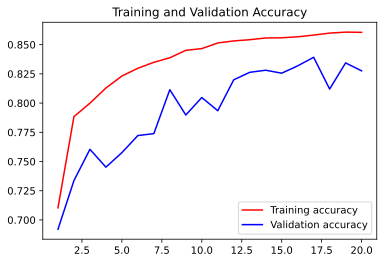

In [17]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('Loss_Accuracy3.svg');

# CNN

### Baseline

- This was the initial model used on the project. The results were poor indicating a massive over fit. The classmode was binary and that was adjusted to categorical for the final model. 
- Results were .86 for Training and .53 for Validation


In [29]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

model = Sequential()

#conv block 1
model.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

#conv block 2
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#conv block 3
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#a fully connected (also called dense) layer at the end
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

#finally convert to values of 0 to 1 using the sigmoid activation function
model.add(Dense(1, activation = "sigmoid"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 94, 94, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 94, 94, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 92, 92, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 32)       

In [30]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

Found 151300 images belonging to 2 classes.
Found 26700 images belonging to 2 classes.


In [31]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

filepath = "Four_Layer_Model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)  
                           
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                    callbacks=callbacks_list)

Epoch 1/20
152/152 [==============================] - 81s 515ms/step - loss: 0.5286 - accuracy: 0.7537 - val_loss: 1.1949 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to Four_Layer_Model.h5
Epoch 2/20
152/152 [==============================] - 78s 512ms/step - loss: 0.4178 - accuracy: 0.8150 - val_loss: 2.2306 - val_accuracy: 0.5351

Epoch 00002: val_accuracy improved from 0.50000 to 0.53513, saving model to Four_Layer_Model.h5
Epoch 3/20
152/152 [==============================] - 78s 513ms/step - loss: 0.3826 - accuracy: 0.8355 - val_loss: 2.0990 - val_accuracy: 0.5296

Epoch 00003: val_accuracy did not improve from 0.53513
Epoch 4/20
152/152 [==============================] - 78s 514ms/step - loss: 0.3597 - accuracy: 0.8458 - val_loss: 1.7997 - val_accuracy: 0.5112

Epoch 00004: val_accuracy did not improve from 0.53513

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 5/20
152/152 [================

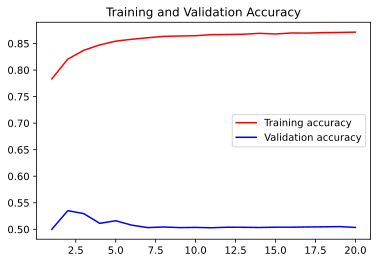

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('Loss_Accuracy4.svg');

# Transfer Learning

### ResNet50
- ResNet50 is a Residual Neural Network that is pre-trained. Layersw were frozen and the Functional API was used to test transfer learning.
- Results were .76 for Training and .76 for Validation

In [19]:
from keras.applications.resnet import ResNet50

base_model = ResNet50(include_top= False, weights='imagenet', input_shape=([96, 96, 3]))

for layer in base_model.layers:
    layer.trainable = False    

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x) 
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

filepath = "Transfer_Model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)  
                           
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                    callbacks=callbacks_list)

94773248/94765736 [==============================] - 2s 0us/step
Epoch 1/20
152/152 [==============================] - 90s 568ms/step - loss: 0.7931 - accuracy: 0.5929 - val_loss: 0.5841 - val_accuracy: 0.7038

Epoch 00001: val_accuracy improved from -inf to 0.70378, saving model to Transfer_Model.h5
Epoch 2/20
152/152 [==============================] - 85s 557ms/step - loss: 0.5734 - accuracy: 0.7076 - val_loss: 0.5555 - val_accuracy: 0.7226

Epoch 00002: val_accuracy improved from 0.70378 to 0.72258, saving model to Transfer_Model.h5
Epoch 3/20
152/152 [==============================] - 84s 553ms/step - loss: 0.5506 - accuracy: 0.7244 - val_loss: 0.5393 - val_accuracy: 0.7322

Epoch 00003: val_accuracy improved from 0.72258 to 0.73221, saving model to Transfer_Model.h5
Epoch 4/20
152/152 [==============================] - 84s 552ms/step - loss: 0.5406 - accuracy: 0.7296 - val_loss: 0.5372 - val_accuracy: 0.7331

Epoch 00004: val_accuracy improved from 0.73221 to 0.73311, saving model

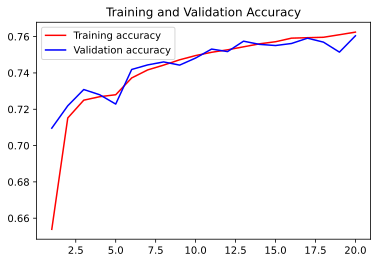

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('Loss_AccuracyT.svg');